# Predicting Drive Failure

First, we import the dataset from BackBlaze

In [1]:
# Downloading datasets
# Using 2016 dataset
from urllib.request import urlretrieve
urls = ["https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2016.zip",\
        "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q2_2016.zip"]
for url in urls:
  !wget {url}

--2024-04-03 09:37:56--  https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2016.zip
Resolving f001.backblazeb2.com (f001.backblazeb2.com)... 104.153.233.181
Connecting to f001.backblazeb2.com (f001.backblazeb2.com)|104.153.233.181|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 270281914 (258M) [application/zip]
Saving to: ‘data_Q1_2016.zip.1’

data_Q1_2016.zip.1  100%[===================>] 257.76M  40.9MB/s    in 5.7s    

2024-04-03 09:38:02 (45.1 MB/s) - ‘data_Q1_2016.zip.1’ saved [270281914/270281914]

--2024-04-03 09:38:02--  https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q2_2016.zip
Resolving f001.backblazeb2.com (f001.backblazeb2.com)... 104.153.233.181
Connecting to f001.backblazeb2.com (f001.backblazeb2.com)|104.153.233.181|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 292369418 (279M) [application/zip]
Saving to: ‘data_Q2_2016.zip.1’

data_Q2_2016.zip.1  100%[===================>] 278.83M  5

In [2]:
# Unzipping contents
!mkdir data
paths = ["/content/data_Q1_2016.zip", "/content/data_Q2_2016.zip"]
store = ["train", "test"]
for i in range(len(paths)-1):
  !unzip -o {paths[i]} -d "/content/data/train"
!unzip -o {paths[-1]} -d "/content/data/test"

Archive:  /content/data_Q1_2016.zip
  inflating: /content/data/train/2016-01-01.csv  
  inflating: /content/data/train/__MACOSX/._2016-01-01.csv  
  inflating: /content/data/train/2016-01-02.csv  
  inflating: /content/data/train/__MACOSX/._2016-01-02.csv  
  inflating: /content/data/train/2016-01-03.csv  
  inflating: /content/data/train/__MACOSX/._2016-01-03.csv  
  inflating: /content/data/train/2016-01-04.csv  
  inflating: /content/data/train/__MACOSX/._2016-01-04.csv  
  inflating: /content/data/train/2016-01-05.csv  
  inflating: /content/data/train/__MACOSX/._2016-01-05.csv  
  inflating: /content/data/train/2016-01-06.csv  
  inflating: /content/data/train/__MACOSX/._2016-01-06.csv  
  inflating: /content/data/train/2016-01-07.csv  
  inflating: /content/data/train/__MACOSX/._2016-01-07.csv  
  inflating: /content/data/train/2016-01-08.csv  
  inflating: /content/data/train/__MACOSX/._2016-01-08.csv  
  inflating: /content/data/train/2016-01-09.csv  
  inflating: /content/data

Next, we import necessary libraries and load the data into a DataFrame

In [3]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error

# Defining a random state
RANDOM = 3856

In [4]:
# Getting all file names or dates
train_path = '/content/data/train'
test_path = '/content/data/test'

train_files = os.listdir(train_path)
train_files.remove("__MACOSX")
train_files.sort(reverse = True)

test_files = os.listdir(test_path)
test_files.remove("__MACOSX")
test_files.sort(reverse = True)

In [5]:
# Columns used
# Originally used because RAM was going too high to load any dataset
# No longer required as we filter out the data as we are loading it
"""cols = ["date", "serial_number", "model","capacity_bytes","failure","smart_1_normalized","smart_5_normalized","smart_187_normalized","smart_188_normalized",\
 "smart_197_normalized","smart_9_normalized","smart_184_normalized","smart_10_normalized","smart_196_normalized","smart_198_normalized",\
 "smart_201_normalized","smart_5_raw","smart_187_raw","smart_188_raw","smart_10_raw","smart_196_raw","smart_198_raw",\
 "smart_197_raw","smart_9_raw", "smart_1_raw","smart_184_raw","smart_201_raw"]"""

'cols = ["date", "serial_number", "model","capacity_bytes","failure","smart_1_normalized","smart_5_normalized","smart_187_normalized","smart_188_normalized", "smart_197_normalized","smart_9_normalized","smart_184_normalized","smart_10_normalized","smart_196_normalized","smart_198_normalized", "smart_201_normalized","smart_5_raw","smart_187_raw","smart_188_raw","smart_10_raw","smart_196_raw","smart_198_raw", "smart_197_raw","smart_9_raw", "smart_1_raw","smart_184_raw","smart_201_raw"]'

In [6]:
# Loading Train Dataset
# We only want data for hard drives that have failed
train = pd.read_csv(train_path + "/" + train_files[0])
train_failed_hdds = train.loc[train.failure==1]["serial_number"]
train = train.loc[train["serial_number"].isin(train_failed_hdds)]
for files in range(1, len(train_files)):
  temp = pd.read_csv(train_path + "/" + train_files[files])
  train = pd.concat([train, temp], ignore_index=True)
  train_failed_hdds = train.loc[train.failure==1]["serial_number"]
  train = train.loc[train["serial_number"].isin(train_failed_hdds)]

# Check
print(train.shape)
train.head()

(14664, 95)


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2016-03-31,S301JLE2,ST4000DM000,4000787030016,1,117.0,140241856.0,NaN,NaN,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-03-31,9VYC10JY,ST3160316AS,160041885696,1,118.0,174815341.0,NaN,NaN,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-03-30,S301JLE2,ST4000DM000,4000787030016,0,107.0,145474256.0,NaN,NaN,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-03-30,9VYC10JY,ST3160316AS,160041885696,0,113.0,58241700.0,NaN,NaN,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-03-30,WD-WX41D94RNPTY,WDC WD60EFRX,6001175126016,1,195.0,223.0,NaN,NaN,203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Loading Test Data
test = pd.read_csv(test_path + "/" + test_files[0])
test_failed_hdds = test.loc[test.failure==1]["serial_number"]
test = test.loc[test["serial_number"].isin(test_failed_hdds)]
for files in range(1, len(test_files)):
  temp = pd.read_csv(test_path + "/" + test_files[files])
  test = pd.concat([test, temp], ignore_index=True)
  test_failed_hdds = test.loc[test.failure==1]["serial_number"]
  test = test.loc[test["serial_number"].isin(test_failed_hdds)]

# Check
print(test.shape)
test.head()

(16470, 95)


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2016-06-30,Z304HZSG,ST4000DM000,4000787030016,1,115,87419384,NaN,NaN,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-06-29,ZA125W0A,ST8000DM002,8001563222016,1,74,28013504,NaN,NaN,98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-06-29,MK0331YHGT1YEA,Hitachi HDS723030ALA640,3000592982016,1,100,0,136.0,81.0,123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-06-29,Z305D6GH,ST4000DM000,4000787030016,1,107,184067580,NaN,NaN,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-06-29,Z304HSV7,ST4000DM000,4000787030016,1,118,180863760,NaN,NaN,98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Finding HDDs that have failed
train_failed_hdds = train.loc[train.failure==1]["serial_number"]
len(train_failed_hdds)

336

In [9]:
test_failed_hdds = test.loc[test.failure==1]["serial_number"]
len(test_failed_hdds)

385

In [10]:
# Checking shape of both datasets
print(train.shape)
print(test.shape)

(14664, 95)
(16470, 95)


Preprocessing the data

In [11]:
# Instead of classifying between failed and not failed drives
# We will be predicting the number of days till failure
# Making it a regression problem
# We, begin by finding number of days till failure
train["end_date"] = train.groupby("serial_number")["date"].transform("max")
train["end_date"] = pd.to_datetime(train["end_date"])
train["date"] = pd.to_datetime(train["date"])
train["date_diff"] = train["end_date"] - train["date"]
train["date_diff"].describe()

count                         14664
mean     29 days 11:27:12.078559738
std      21 days 03:02:49.794957763
min                 0 days 00:00:00
25%                12 days 00:00:00
50%                26 days 00:00:00
75%                45 days 00:00:00
max                90 days 00:00:00
Name: date_diff, dtype: object

In [12]:
# Performing the same with test data
test["end_date"] = test.groupby("serial_number")["date"].transform("max")
test["end_date"] = pd.to_datetime(test["end_date"])
test["date"] = pd.to_datetime(test["date"])
test["date_diff"] = test["end_date"] - test["date"]
test["date_diff"].describe()

count                         16470
mean     28 days 11:03:04.918032787
std      20 days 18:07:22.644901873
min                 0 days 00:00:00
25%                11 days 00:00:00
50%                25 days 00:00:00
75%                43 days 00:00:00
max                90 days 00:00:00
Name: date_diff, dtype: object

In [13]:
train.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw,end_date,date_diff
0,2016-03-31,S301JLE2,ST4000DM000,4000787030016,1,117.0,140241856.0,NaN,NaN,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-31,0 days
1,2016-03-31,9VYC10JY,ST3160316AS,160041885696,1,118.0,174815341.0,NaN,NaN,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-31,0 days
2,2016-03-30,S301JLE2,ST4000DM000,4000787030016,0,107.0,145474256.0,NaN,NaN,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-31,1 days
3,2016-03-30,9VYC10JY,ST3160316AS,160041885696,0,113.0,58241700.0,NaN,NaN,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-31,1 days
4,2016-03-30,WD-WX41D94RNPTY,WDC WD60EFRX,6001175126016,1,195.0,223.0,NaN,NaN,203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-30,0 days


In [14]:
# Handling null values
train.isnull().sum()

date                        0
serial_number               0
model                       0
capacity_bytes              0
failure                     0
                        ...  
smart_254_raw           12922
smart_255_normalized    14664
smart_255_raw           14664
end_date                    0
date_diff                   0
Length: 97, dtype: int64

In [15]:
# Dropping colums which have NaN values for more than 95% of the dataset
train = train[train.columns[~(train.isna().sum().values/len(train) > 0.05)]]
# For remaining NaN values we drop the rows
train.dropna(inplace = True)
# Redefining the index
train.reset_index(inplace=True, drop=True)
# Checking if NaN values are gone
train.isnull().sum()

<ipython-input-15-e92d8c88fac0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace = True)


date                    0
serial_number           0
model                   0
capacity_bytes          0
failure                 0
smart_1_normalized      0
smart_1_raw             0
smart_3_normalized      0
smart_3_raw             0
smart_4_normalized      0
smart_4_raw             0
smart_5_normalized      0
smart_5_raw             0
smart_7_normalized      0
smart_7_raw             0
smart_9_normalized      0
smart_9_raw             0
smart_10_normalized     0
smart_10_raw            0
smart_12_normalized     0
smart_12_raw            0
smart_194_normalized    0
smart_194_raw           0
smart_197_normalized    0
smart_197_raw           0
smart_198_normalized    0
smart_198_raw           0
smart_199_normalized    0
smart_199_raw           0
end_date                0
date_diff               0
dtype: int64

In [16]:
# Taking columns that are shortlisted for train
test = test[train.columns]
# For remaining NaN values we drop the rows
test.dropna(inplace = True)
# Redefining the index
test.reset_index(inplace=True, drop=True)
# Checking if NaN values are gone
test.isnull().sum()

<ipython-input-16-2a58ebbc65da>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.dropna(inplace = True)


date                    0
serial_number           0
model                   0
capacity_bytes          0
failure                 0
smart_1_normalized      0
smart_1_raw             0
smart_3_normalized      0
smart_3_raw             0
smart_4_normalized      0
smart_4_raw             0
smart_5_normalized      0
smart_5_raw             0
smart_7_normalized      0
smart_7_raw             0
smart_9_normalized      0
smart_9_raw             0
smart_10_normalized     0
smart_10_raw            0
smart_12_normalized     0
smart_12_raw            0
smart_194_normalized    0
smart_194_raw           0
smart_197_normalized    0
smart_197_raw           0
smart_198_normalized    0
smart_198_raw           0
smart_199_normalized    0
smart_199_raw           0
end_date                0
date_diff               0
dtype: int64

In [17]:
# Dropping unwanted columns for training
train = train.drop(['date', 'serial_number', 'model','end_date'], axis=1)
test = test.drop(['date', 'serial_number', 'model','end_date'], axis=1)
train.head()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_12_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,date_diff
0,4000787030016,1,117.0,140241856.0,95.0,0.0,100.0,5.0,100.0,0.0,...,5.0,27.0,27.0,100.0,16.0,100.0,16.0,200.0,0.0,0 days
1,160041885696,1,118.0,174815341.0,97.0,0.0,100.0,70.0,100.0,0.0,...,35.0,31.0,31.0,100.0,0.0,100.0,0.0,200.0,0.0,0 days
2,4000787030016,0,107.0,145474256.0,95.0,0.0,100.0,5.0,100.0,0.0,...,5.0,27.0,27.0,100.0,0.0,100.0,0.0,200.0,0.0,1 days
3,160041885696,0,113.0,58241700.0,97.0,0.0,100.0,70.0,100.0,0.0,...,35.0,31.0,31.0,100.0,0.0,100.0,0.0,200.0,0.0,1 days
4,6001175126016,1,195.0,223.0,203.0,8833.0,100.0,9.0,200.0,0.0,...,9.0,125.0,27.0,200.0,9.0,100.0,0.0,200.0,0.0,0 days


In [18]:
# Splitting target variable
train_Y = train["date_diff"].dt.days
train_X = train.drop(["date_diff"],axis=1)
test_Y = test["date_diff"].dt.days
test_X = test.drop(["date_diff"],axis=1)

In [19]:
# Performing train and validation split, 20% for validation
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2, random_state=RANDOM, shuffle = True)
# Print the shapes of the resulting splits
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_valid:", X_valid.shape, "y_valid:", y_valid.shape)

X_train: (11730, 26) y_train: (11730,)
X_valid: (2933, 26) y_valid: (2933,)


In [20]:
X_train.head()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_12_normalized,smart_12_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw
13758,3000592982016,0,200.0,0.0,174.0,6300.0,100.0,45.0,200.0,0.0,...,100.0,41.0,129.0,21.0,200.0,0.0,100.0,0.0,200.0,0.0
11630,320072933376,0,120.0,241180992.0,98.0,0.0,100.0,10.0,100.0,0.0,...,100.0,10.0,28.0,28.0,100.0,0.0,100.0,0.0,200.0,0.0
630,160041885696,0,117.0,135208900.0,97.0,0.0,100.0,70.0,100.0,0.0,...,100.0,35.0,31.0,31.0,100.0,0.0,100.0,0.0,200.0,0.0
474,4000787030016,0,103.0,5482544.0,96.0,0.0,100.0,4.0,100.0,0.0,...,100.0,4.0,26.0,26.0,100.0,0.0,100.0,0.0,200.0,0.0
9551,4000787030016,0,119.0,214059776.0,91.0,0.0,100.0,12.0,100.0,0.0,...,100.0,12.0,28.0,28.0,100.0,24.0,100.0,24.0,200.0,0.0


In [21]:
X_valid.head()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_12_normalized,smart_12_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw
11709,4000787030016,0,119.0,217529456.0,94.0,0.0,100.0,6.0,100.0,0.0,...,100.0,6.0,30.0,30.0,100.0,0.0,100.0,0.0,200.0,0.0
13031,4000787030016,0,117.0,125493288.0,96.0,0.0,100.0,4.0,100.0,0.0,...,100.0,4.0,30.0,30.0,100.0,0.0,100.0,0.0,200.0,0.0
2931,4000787030016,0,114.0,82368192.0,93.0,0.0,100.0,7.0,100.0,0.0,...,100.0,7.0,30.0,30.0,100.0,0.0,100.0,0.0,200.0,0.0
10458,320072933376,0,200.0,0.0,139.0,4016.0,100.0,9.0,200.0,0.0,...,100.0,8.0,106.0,37.0,200.0,0.0,100.0,0.0,200.0,0.0
3669,4000787030016,0,109.0,21760600.0,94.0,0.0,100.0,6.0,100.0,0.0,...,100.0,6.0,25.0,25.0,100.0,0.0,100.0,0.0,200.0,24.0


Finally, we train a few models and compare them

In [22]:
linear_model = LinearRegression().fit(X_train, y_train)
linear_pred = linear_model.predict(X_valid)
print("Linear Regression MSE:", mean_squared_error(y_valid, linear_pred))
print("Linear Regression R2 score:", linear_model.score(X_valid, y_valid))
print("-------------------------------------")

lasso_model = Lasso(random_state = RANDOM).fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_valid)
print("Lasso Regression MSE:", mean_squared_error(y_valid, lasso_pred))
print("Lasso Regression R2 score:", lasso_model.score(X_valid, y_valid))
print("-------------------------------------")

random_model = RandomForestRegressor(random_state = RANDOM).fit(X_train, y_train)
random_pred = random_model.predict(X_valid)
print("Random Forest MSE:", mean_squared_error(y_valid, random_pred))
print("Random Forest R2 score:", random_model.score(X_valid, y_valid))
print("-------------------------------------")

tree_model = DecisionTreeRegressor(random_state = RANDOM).fit(X_train, y_train)
tree_pred = tree_model.predict(X_valid)
print("Decision Tree MSE:", mean_squared_error(y_valid, tree_pred))
print("Decision Tree R2 score:", tree_model.score(X_valid, y_valid))
print("-------------------------------------")

Linear Regression MSE: 419.72288667245175
Linear Regression R2 score: 0.0754217395496829
-------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.533e+06, tolerance: 5.213e+02
  model = cd_fast.enet_coordinate_descent(


Lasso Regression MSE: 440.72695750671375
Lasso Regression R2 score: 0.0291533374897488
-------------------------------------
Random Forest MSE: 16.115240879645413
Random Forest R2 score: 0.964500860323902
-------------------------------------
Decision Tree MSE: 33.65700647800887
Decision Tree R2 score: 0.9258593288821843
-------------------------------------


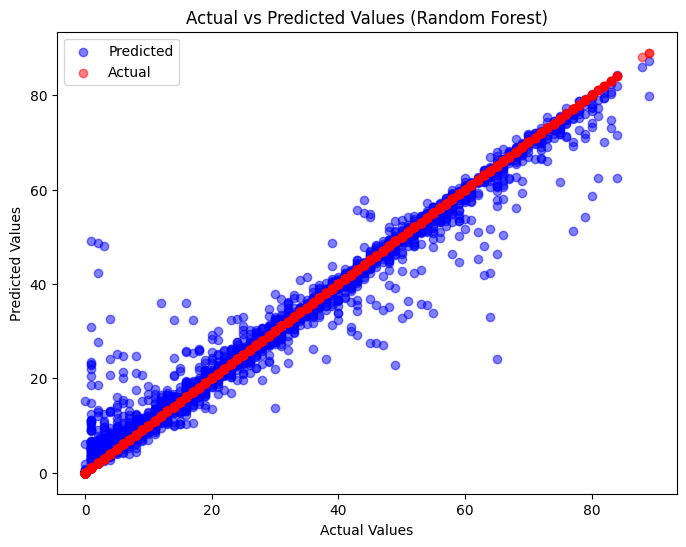

In [23]:
# Visualizing Actual vs Predicted values with different colors
plt.figure(figsize=(8, 6))
plt.scatter(y_valid, random_pred, alpha=0.5, label='Predicted', color='blue')
plt.scatter(y_valid, y_valid, alpha=0.5, label='Actual', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Random Forest)')
plt.legend()
plt.show()

Now, we try to optimize hyperparameters in the relatively better models<br>
* Random Forest

In [25]:
random_param = {"n_estimators": randint(150,250), "criterion":['squared_error', 'friedman_mse', 'poisson'], "max_depth": randint(20,30)}
random_CV = RandomizedSearchCV(RandomForestRegressor(random_state = RANDOM), random_param, random_state = RANDOM)
random_CV.fit(train_X, train_Y)

print("Best Params: ", random_CV.best_params_)

randomCV_pred = random_CV.predict(train_X)
print("Train MSE: ", mean_squared_error(train_Y, randomCV_pred))
print("Train R2: ", random_CV.score(train_X, train_Y))

randomCV_pred_test = random_CV.predict(test_X)
print("Test MSE: ", mean_squared_error(test_Y, randomCV_pred_test))
print("Test R2: ", random_CV.score(test_X, test_Y))

Best Params:  {'criterion': 'friedman_mse', 'max_depth': 29, 'n_estimators': 228}
Train MSE:  5.230829879872736
Train R2:  0.9882795877947045
Test MSE:  596.9920434452297
Test R2:  -0.38593952735027703


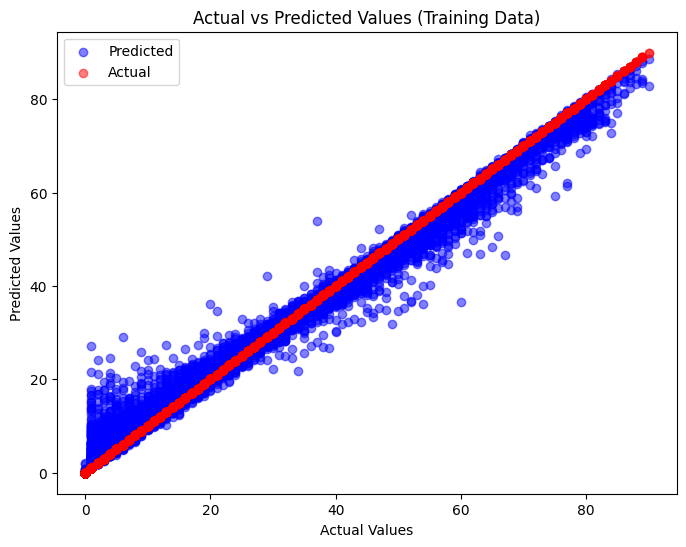

In [26]:
# Visualizing Actual vs Predicted values with different colors
plt.figure(figsize=(8, 6))
plt.scatter(train_Y, randomCV_pred, alpha=0.5, label='Predicted', color='blue')
plt.scatter(train_Y, train_Y, alpha=0.5, label='Actual', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Training Data)')
plt.legend()
plt.show()

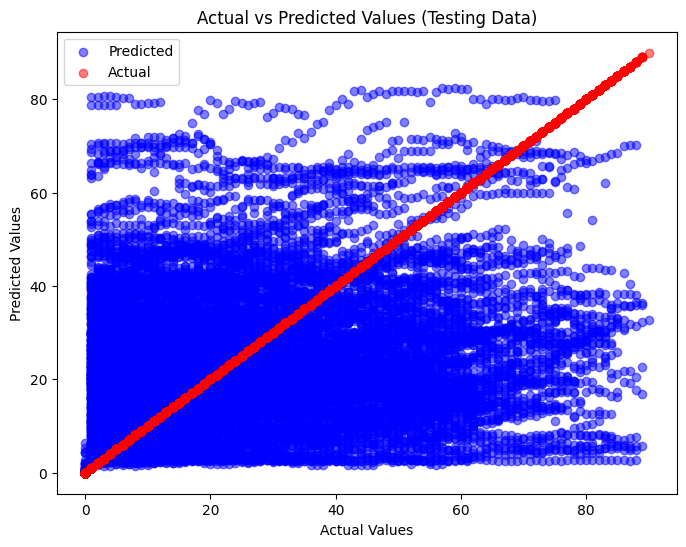

In [27]:
# Visualizing Actual vs Predicted values with different colors
plt.figure(figsize=(8, 6))
plt.scatter(test_Y, randomCV_pred_test, alpha=0.5, label='Predicted', color='blue')
plt.scatter(test_Y, test_Y, alpha=0.5, label='Actual', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Testing Data)')
plt.legend()
plt.show()